# Python based Limit Calculator

This repository contains a Python script to calculate asymptotic limits using signal and background data from input files. The script provides an alternative way to perform limit calculations without using CMSSW.

## Input file structure.

## Prerequisites
- Python 3.x
- NumPy
- SciPy

In [1]:
import os,sys
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
print('Modules loaded.')

Modules loaded.


## Generating dummy data for testing

In [2]:
os.makedirs('dummy_data', exist_ok=True)
generate_new = False

modeldict = {
    'M100' :{'mass':100,  'accp':0.10},
    'M200' :{'mass':200,  'accp':0.15},
    'M300' :{'mass':300,  'accp':0.20},
    'M400' :{'mass':400,  'accp':0.25},
    'M500' :{'mass':500,  'accp':0.30},
    'M600' :{'mass':600,  'accp':0.35},
    'M700' :{'mass':700,  'accp':0.40},
    'M800' :{'mass':800,  'accp':0.45},
    'M1000':{'mass':1000, 'accp':0.50},
}

lumi = 59800

bins = 20
signal_mean = 0.1
bkg_mean = 10000

# Function to generate the background file
def generate_dummy_background():
    bkg_file = 'dummy_data/obs_exp.txt'
    exp = np.random.poisson(bkg_mean, bins)
    err = np.sqrt(exp)  # Uncertainty in background
    obs = exp + np.random.poisson(1000, bins)  # Simulated observed data
    np.savetxt(bkg_file, np.vstack((np.arange(bins), obs, exp, err)).T, header='bin\tD\tB\tdB', fmt='%d', delimiter='\t')

# Function to generate signal files
def generate_dummy_signal():
    for name, val in modeldict.items():
        signal_file = f'dummy_data/sig_M{val["mass"]}.txt'
        signal_data = np.random.poisson(signal_mean, bins)
        np.savetxt(signal_file, np.vstack((np.arange(bins), signal_data)).T, header='bin\tS', fmt='%d', delimiter='\t')

if generate_new:
    generate_dummy_background()
    generate_dummy_signal()
    print('Dummy data generated.')

In [3]:
import numpy as np
from scipy.stats import poisson

def calculate_combined_limits(modeldict, lumi):
    limits = []

    # Load background data
    data = np.loadtxt('dummy_data/obs_exp.txt', delimiter='\t', skiprows=1)
    obs = data[:, 1]
    exp = data[:, 2]
    err = data[:, 3]
    
    # Calculate sums
    obs_sum = np.sum(obs)
    bkg_sum = np.sum(exp)
    bkg_err = np.sqrt(np.sum(err**2))
    
    # Define function to calculate Poisson upper limit
    def calculate_limit(observed, expected, uncertainty):
        return poisson.ppf(0.95, observed + expected) - expected

    # Calculate the expected and observed limits
    combined_expected_limit = calculate_limit(bkg_sum, bkg_sum, bkg_err)
    combined_observed_limit = calculate_limit(obs_sum, bkg_sum, bkg_err)

    sigma_stat = np.sqrt(bkg_sum)
    sigma_sys  = 0.1 * combined_expected_limit #Assuming 10% sys unc
    sigma      = np.sqrt(sigma_stat**2 + sigma_sys**2) 

    print(f'nobs = {obs_sum:.0f}\nnexp = {bkg_sum:.2f} +- {bkg_err:.2f}')
    print(f'Limit on N = {combined_observed_limit:.2f} ({combined_expected_limit:.2f} +- {sigma:.2f})')
    
    for model, val in modeldict.items():
        sigma_lim_expected = combined_expected_limit/(val['accp'] * lumi)
        sigma_lim_observed = combined_observed_limit/(val['accp'] * lumi)
        limits.append({
            'mass': val['mass'],
            'expected_limit': sigma_lim_expected,
            'observed_limit': sigma_lim_observed,
            'sigma': sigma/(val['accp'] * lumi)
        })
    
    return limits

limits = calculate_combined_limits(modeldict, 59800)

nobs = 219696
nexp = 199784.00 +- 444.76
Limit on N = 220762.00 (200824.00 +- 20087.37)


In [4]:
limits

[{'mass': 100,
  'expected_limit': 33.582608695652176,
  'observed_limit': 36.91672240802676,
  'sigma': 3.359092556994568},
 {'mass': 200,
  'expected_limit': 22.38840579710145,
  'observed_limit': 24.611148272017836,
  'sigma': 2.239395037996379},
 {'mass': 300,
  'expected_limit': 16.791304347826088,
  'observed_limit': 18.45836120401338,
  'sigma': 1.679546278497284},
 {'mass': 400,
  'expected_limit': 13.433043478260869,
  'observed_limit': 14.766688963210703,
  'sigma': 1.3436370227978274},
 {'mass': 500,
  'expected_limit': 11.194202898550724,
  'observed_limit': 12.305574136008918,
  'sigma': 1.1196975189981895},
 {'mass': 600,
  'expected_limit': 9.595031055900622,
  'observed_limit': 10.54763497372193,
  'sigma': 0.9597407305698766},
 {'mass': 700,
  'expected_limit': 8.395652173913044,
  'observed_limit': 9.22918060200669,
  'sigma': 0.839773139248642},
 {'mass': 800,
  'expected_limit': 7.4628019323671495,
  'observed_limit': 8.203716090672613,
  'sigma': 0.7464650126654596

In [5]:
def find_signal_yields(modeldict):
    
    for model, val in modeldict.items():
        signal_file = f'dummy_data/sig_M{val["mass"]}.txt'
        signal_data = np.loadtxt(signal_file, delimiter='\t', skiprows=1, usecols=1)
        total_signal_yield = np.sum(signal_data)
        modeldict[model]['yield'] = total_signal_yield
    
find_signal_yields(modeldict)

In [6]:
modeldict

{'M100': {'mass': 100, 'accp': 0.1, 'yield': 2.0},
 'M200': {'mass': 200, 'accp': 0.15, 'yield': 0.0},
 'M300': {'mass': 300, 'accp': 0.2, 'yield': 4.0},
 'M400': {'mass': 400, 'accp': 0.25, 'yield': 3.0},
 'M500': {'mass': 500, 'accp': 0.3, 'yield': 3.0},
 'M600': {'mass': 600, 'accp': 0.35, 'yield': 1.0},
 'M700': {'mass': 700, 'accp': 0.4, 'yield': 2.0},
 'M800': {'mass': 800, 'accp': 0.45, 'yield': 1.0},
 'M1000': {'mass': 1000, 'accp': 0.5, 'yield': 1.0}}

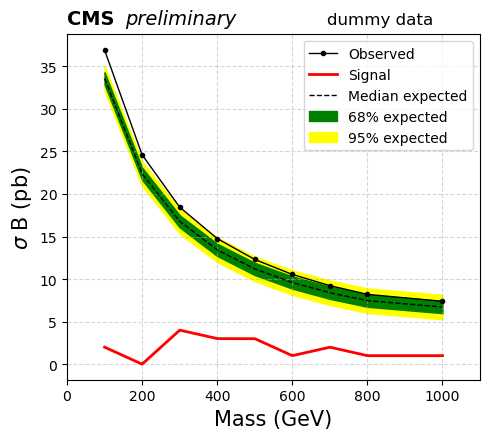

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def plot_limits(limits, modeldict):
    fig, ax = plt.subplots(figsize=(5, 4.5))  # Set figure size to (5, 4)

    # Extract data from limits
    mass = np.array([result['mass'] for result in limits])
    lim_exp = np.array([result['expected_limit'] for result in limits])
    lim_obs = np.array([result['observed_limit'] for result in limits])
    sigma = np.array([result['sigma'] for result in limits])
    signal = np.array([entry['yield'] for entry in modeldict.values()])

    #Interpolation for signal and expected limits:
    '''
    # Check if the number of data points is sufficient for cubic interpolation
    if len(mass) >= 4:
        interp_exp = interp1d(mass, lim_exp, kind='cubic', fill_value='extrapolate')
        interp_sig = interp1d(mass, signal, kind='cubic', fill_value='extrapolate')
    elif len(mass) == 3:
        interp_exp = interp1d(mass, lim_exp, kind='quadratic', fill_value='extrapolate')
        interp_sig = interp1d(mass, signal, kind='quadratic', fill_value='extrapolate')
    else:
        interp_exp = interp1d(mass, lim_exp, kind='linear', fill_value='extrapolate')
        interp_sig = interp1d(mass, signal, kind='linear', fill_value='extrapolate')
    '''
    kind=interpolation_type = 'linear'
    interp_exp = interp1d(mass, lim_exp, kind=interpolation_type, fill_value='extrapolate')
    interp_sig = interp1d(mass, signal,  kind=interpolation_type, fill_value='extrapolate')

    mass_smooth = np.linspace(min(mass), max(mass), 500)
    exp_smooth = interp_exp(mass_smooth)
    sig_smooth = interp_sig(mass_smooth)

    # 2 Sigma Band
    upper_2sigma = exp_smooth + sigma.mean()
    lower_2sigma = exp_smooth - sigma.mean()
    ax.fill_between(mass_smooth, lower_2sigma, upper_2sigma, color='yellow', label='95% expected')
    
    # 1 Sigma Band
    upper_1sigma = exp_smooth + sigma.mean() / 2
    lower_1sigma = exp_smooth - sigma.mean() / 2
    ax.fill_between(mass_smooth, lower_1sigma, upper_1sigma, color='green', label='68% expected')

    # Plot smooth lines for expected limit and signal yield
    ax.plot(mass_smooth, exp_smooth, linestyle='--', linewidth=1, color='black', label='Median expected')
    ax.plot(mass_smooth, sig_smooth, linestyle='-',  linewidth=2, color='red',   label='Signal')

    # Plot observed limit with dots
    ax.plot(mass, lim_obs, linestyle='-', linewidth=1, marker='o', markersize=3, color='black', label='Observed')

    handles, labels = ax.get_legend_handles_labels()
    order = list(range(len(labels)))
    order.reverse()
    
    # Add labels, title, and legend
    ax.set_xlabel('Mass (GeV)', fontsize=15)
    ax.set_ylabel('$\sigma$ B (pb)', fontsize=15)
    ax.set_xlim(min(mass) - 100, max(mass) + 100)
    #ax.set_yscale('log')
    ax.legend([handles[i] for i in order], [labels[i] for i in order])
    ax.grid(True, linestyle='--', alpha=0.5)

    ax.text(0,    1.03, "CMS",                     transform=ax.transAxes, fontsize=14, fontweight='bold')
    ax.text(0.14, 1.03, "preliminary",             transform=ax.transAxes, fontsize=14, fontstyle='italic')
    ax.text(0.63, 1.03, "dummy data", transform=ax.transAxes, fontsize=12)
    
    plt.tight_layout()
    plt.show()

plot_limits(limits, modeldict)